# Introduction

Welcome to the **Few Shot Object Detection for TensorFlow Lite** Colab. Here, we demonstrate fine tuning of a SSD architecture (pre-trained on COCO) on very few examples of a *novel* class. We will then generate a (downloadable) TensorFlow Lite model for on-device inference.

**NOTE:** This Colab is meant for the few-shot detection use-case. To train a model on a large dataset, please follow the [TF2 training](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_training_and_evaluation.md#training) documentation and then [convert](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md) the model to TensorFlow Lite.

# Set Up

## Imports

In [5]:
# Support for TF2 models was added after TF 2.3.
!pip install tf-nightly-gpu

import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 403.7MB 43kB/s 
     |████████████████████████████████| 5.9MB 47.3MB/s 
     |████████████████████████████████| 4.0MB 45.2MB/s 
     |████████████████████████████████| 4.0MB 50.0MB/s 
     |████████████████████████████████| 471kB 61.8MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
2.5.0-dev20210204


In [6]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2399, done.
remote: Counting objects: 100% (2399/2399), done.
remote: Compressing objects: 100% (1997/1997), done.
remote: Total 2399 (delta 573), reused 1395 (delta 375), pack-reused 0
Receiving objects: 100% (2399/2399), 30.77 MiB | 37.96 MiB/s, done.
Resolving deltas: 100% (573/573), done.


In [7]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1618454 sha256=7913b86245e78f0d87a9e236a3ece644cb51fc82b9e70ea7eb87850f30354afc
  Stored in directory: /tmp/pip-ephem-wheel-cache-77j9lo3v/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=2a2d37dc9c624f9fe40796042393d247332bacc3eb1d00fe6c4aa7a1ba79e609
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78533 sha256=c1d9708c67ebe64e41cad3efb34bea2154da228f04ea0e60428480ad4943579d
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for hdfs: filename=hdfs-2.5.8-cp36-none-any.whl size=33213 sha256=24171d6d4200d9b391868b009d412eddeba9ad9738ae5513b36cf1cca5

ERROR: tf-nightly-gpu 2.5.0.dev20210204 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tf-nightly-gpu 2.5.0.dev20210204 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.27.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [8]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
import random

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

## Initalize all possible random seeds

This is a must for having reproducible results.

In [9]:
# Feel free to add anything more here that might generate random numbers
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

## Download images

In [10]:
!mkdir train_data
!gsutil -q  cp  gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv ./train_data/ && echo "CSV Downloaded."
!gsutil  -q -m cp  -r gs://cloud-ml-data/img/openimage/* ./train_data/ && echo "Images copied."


CSV Downloaded.
Images copied.


## Data Cleaning

In [11]:
import re

data = pd.read_csv('./train_data/csv/salads_ml_use.csv', header=None, names=['dataset', 'path', 'label', 'x0', 'y0', 'e1', 'e2', 'x1', 'y1', 'e3', 'e4'])

data.path = data.path.apply(lambda x : re.sub(r'gs:\/\/cloud\-ml\-data\/img\/openimage', r'train_data', x))
data.pop('e1')
data.pop('e2')
data.pop('e3')
data.pop('e4')

data.head()

,dataset,path,label,x0,y0,x1,y1
0,TEST,train_data/103/279324025_3e74a32a84_o.jpg,Baked Goods,0.005743,0.084985,0.567511,0.735736
1,TEST,train_data/103/279324025_3e74a32a84_o.jpg,Salad,0.402759,0.310473,1.000000,0.982695
2,TEST,train_data/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.000000,0.000000,0.054865,0.480665
3,TEST,train_data/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.041131,0.401678,0.318230,0.785916
4,TEST,train_data/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.116263,0.065161,0.451528,0.286489


## Extract number of images that should be recognized

Number of unique classes found in the dataset: 5


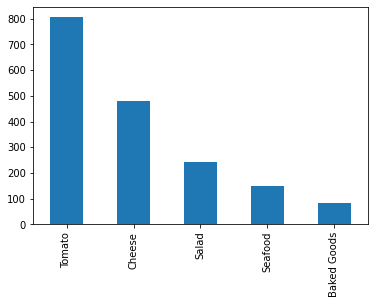

In [12]:
unique_classes = list(data['label'].sort_values().unique())
num_classes = len(unique_classes)

print(f'Number of unique classes found in the dataset: {len(unique_classes)}')
data['label'].value_counts().plot.bar()

##Utilities

In [13]:
import cv2


def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  image = image.resize((320,320))
  return np.array(image.getdata()).reshape(
      (320, 320, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


## Salad data

We will start with some  data consisting of  images of a salads.  Note that the [COCO](https://cocodataset.org/#explore) dataset contains a number of things, but notably, it does *not* contain salads, so this is a novel class.

In [14]:
for i in data.path.values[0:5]:
  print(i)

train_data/103/279324025_3e74a32a84_o.jpg
train_data/103/279324025_3e74a32a84_o.jpg
train_data/1064/3167707458_7b2eebed9e_o.jpg
train_data/1064/3167707458_7b2eebed9e_o.jpg
train_data/1064/3167707458_7b2eebed9e_o.jpg


In [15]:
# Image preprocessing utils
def preprocess_image(image_path, height, width):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    original_image = img
    resized_img = tf.image.resize(img, (height, width))
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image

In [16]:
# Load images
train_images_np = []

for path in data.path:
    train_images_np.append(load_image_into_numpy_array(path))
    images_processed_cnt = len(train_images_np)
    if images_processed_cnt % 100 == 0 and images_processed_cnt > 0:
      print(f'Images loaded: {images_processed_cnt}')

print(f'images_processed_cnt: {len(train_images_np)}')

Images loaded: 100
Images loaded: 200
Images loaded: 300
Images loaded: 400
Images loaded: 500
Images loaded: 600
Images loaded: 700
Images loaded: 800
Images loaded: 900
Images loaded: 1000
Images loaded: 1100
Images loaded: 1200
Images loaded: 1300
Images loaded: 1400
Images loaded: 1500
Images loaded: 1600
Images loaded: 1700
images_processed_cnt: 1757


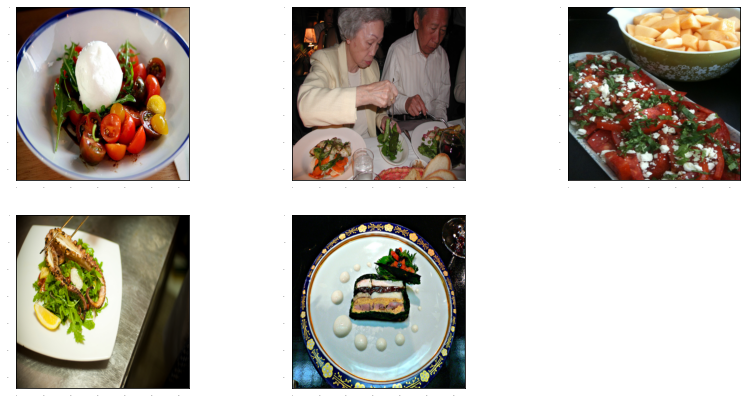

In [17]:
# Visualize first 5 images found in the csv file
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

#for idx, train_image_np in enumerate(np.unique(train_images_np)[0:5]):
for idx, train_image_np in enumerate(np.unique(train_images_np, axis=0)[0:5]):

  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Transfer Learning


## Data Preparation

First, we populate the groundtruth with pre-annotated bounding boxes.

We then add the class annotations (for simplicity, we assume a single 'Duck' class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [ ]:
data.head()

## Building category index

In [19]:
category_index = {}

# We start counting with 1, the 0 is reserved for 'recognizing' the background
for category_id in range(num_classes):
  category_index[category_id + 1] = {'id': category_id + 1, 'name': unique_classes[category_id]}
print(f'category_index: {category_index}')

foreach 

category_index: {1: {'id': 1, 'name': 'Baked Goods'}, 2: {'id': 2, 'name': 'Cheese'}, 3: {'id': 3, 'name': 'Salad'}, 4: {'id': 4, 'name': 'Seafood'}, 5: {'id': 5, 'name': 'Tomato'}}


In [41]:
# gt_boxes = [
#            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
#            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
#            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
#            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
#            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
#]

gt_boxes= []
gt_box_class_indexes=[]

for _, row in data.iterrows():
  gt_box_class_indexes.append(unique_classes.index(row['label']))
  x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
  gt_boxes.append(np.array([[x0, y0, x1, y1]], dtype=np.float32));

# gt_boxes = data['x1','y1', 'x2', 'y2'] ???

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
# duck_class_id = 1
# num_classes = 1

# category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

print(f'len(train_images_np): {len(train_images_np)}')
print(f'len(gt_boxes): {len(gt_boxes)}')

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')
print(f'Training recourds count: {len(gt_classes_one_hot_tensors)}')

len(train_images_np): 1757
len(gt_boxes): 1757
Done prepping data.
Training recourds count: 1757


Let's just visualize the salad images as a sanity check. Don't trust the results, for now.


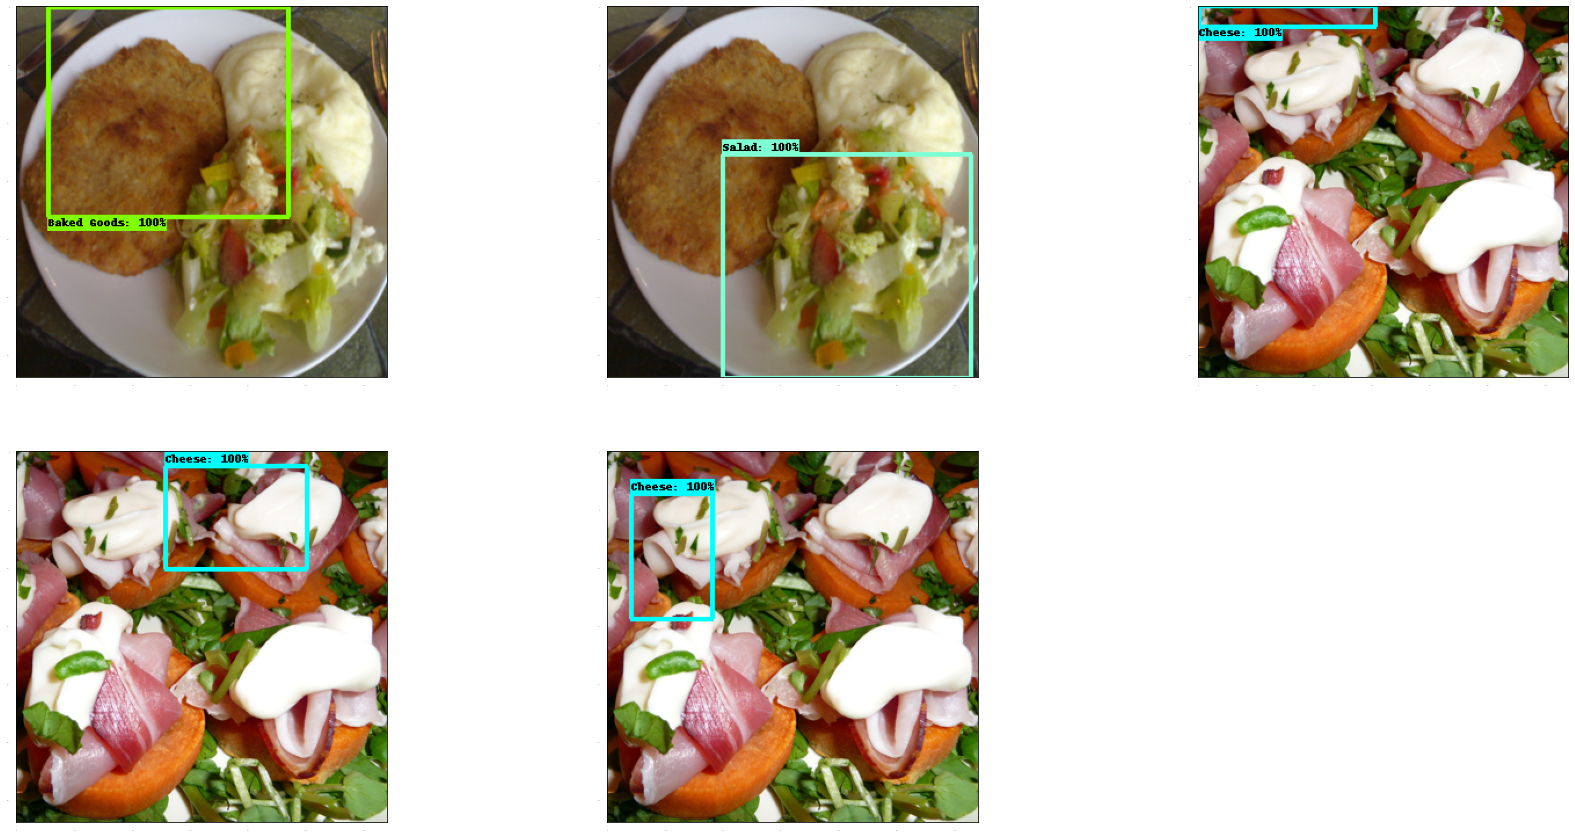

In [42]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      [unique_classes.index(data['label'].iloc[idx]) + 1],
      dummy_scores, category_index)

plt.show()

## Load mobile-friendly model

In this cell we build a mobile-friendly single-stage detection architecture (SSD MobileNet V2 FPN-Lite) and restore all but the classification layer at the top (which will be randomly initialized).

**NOTE**: TensorFlow Lite only supports SSD models for now.

For simplicity, we have hardcoded a number of things in this colab for the specific SSD architecture at hand (including assuming that the image size will always be 320x320), however it is not difficult to generalize to other model configurations (`pipeline.config` in the zip downloaded from the [Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.)).




In [22]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-02-06 19:14:24--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.15.112, 2607:f8b0:4004:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.15.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  80.5MB/s    in 0.2s    

2021-02-06 19:14:25 (80.5 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



In [23]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


## Eager training loop (Fine-tuning)

Some of the parameters in this block have been set empirically: for example, `learning_rate`, `num_batches` & `momentum` for SGD. These are just a starting point, you will have to tune these for your data & model architecture to get the best results.





In [24]:
%%time

tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 32
learning_rate = 0.15
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 100 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

Start fine-tuning!
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function get_model_train_step_function.<locals>.train_step_fn at 0x7fa7bbcc2378>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function get_model_train_step_function.<locals>.train_step_fn at 0x

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:440: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 100, loss=1.9400051
Done fine-tuning!
Checkpoint saved!
CPU times: user 7min 4s, sys: 12.6 s, total: 7min 16s
Wall time: 3min 53s


Last finetuning duration: # please change this after the training you are interested to measure...

CPU times: user 12min 28s, sys: 28.7 s, total: 12min 57s
Wall time: 6min 49s

# Export & run with TensorFlow Lite



## Model Conversion

First, we invoke the `export_tflite_graph_tf2.py` script to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

To know more about this process, please look at [this documentation](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md).

In [ ]:
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

In [ ]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

## Test .tflite model

In [ ]:
# test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 10):
  image_path = data['path'][i]
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor)
  print(classes[0], scores[0])

  plot_detections(
      test_images_np[i][0],
      boxes[0],
      classes[0].astype(np.uint32) + label_id_offset,
      scores[0],
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

plot_detections(
      test_images_np[i][0],
      boxes[0],
      classes[0].astype(np.uint32) + label_id_offset,
      scores[0],
      category_index, figsize=(15, 20))

In [ ]:
# imageio.plugins.freeimage.download()

# anim_file = 'duckies_test.gif'

# filenames = glob.glob('gif_frame_*.jpg')
# filenames = sorted(filenames)
# last = -1
# images = []
# for filename in filenames:
#   image = imageio.imread(filename)
#   images.append(image)

# imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

# display(IPyImage(open(anim_file, 'rb').read()))

## (Optional) Download model

This model can be run on-device with **TensorFlow Lite**. Look at [our SSD model signature](https://www.tensorflow.org/lite/models/object_detection/overview#uses_and_limitations) to understand how to interpret the model IO tensors. Our [Object Detection example](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection) is a good starting point for integrating the model into your mobile app.

Refer to TFLite's [inference documentation](https://www.tensorflow.org/lite/guide/inference) for more details.

In [29]:
# from google.colab import files
# files.download('tflite/model.tflite') 